# AI-EMI-Prediction: Intelligent EMI Eligibility and Risk Prediction System

# 🧾 Project Overview / Summary

The EMI_Predict_AI project is a machine learning–driven financial decision-support system designed to help banks and lending institutions automatically evaluate loan applicants.
It predicts both:

EMI Eligibility Category — classifies applicants as Eligible, High Risk, or Not Eligible

Maximum Affordable EMI Amount (₹) — estimates a safe monthly repayment limit

The system integrates classification and regression models, uses real-time feature engineering, and provides a professional, dark-themed Streamlit dashboard with four sections:

🏠 Dashboard Overview – Key dataset insights and statistics

🔍 Eligibility Predictor – Real-time classification of loan eligibility

💰 EMI Affordability Estimator – Regression-based EMI prediction

📊 Model Insights – Confusion matrix, ROC curves, and feature importance

With this dual-model approach, EMI_Predict_AI enhances credit assessment accuracy, reduces manual workload, and improves risk transparency in financial decision-making.

# Github-link : https://github.com/Akdas-DS/AI-EMI-Prediction-Intelligent-EMI-Eligibility-and-Risk-Prediction-System.git
# Streamlit-app-link: https://akdas-ds-ai-emi-prediction-intelligent-emi-eligibili-app-vmuq7i.streamlit.app/

In [1]:
# Cell 4: Import Necessary Libraries
# -------------------------------------------------------------
# Importing required packages for data handling, visualization, modeling, and deployment.
# The notebook handles optional libraries (mlflow) gracefully if they're not installed.

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, r2_score
)

import pickle
import warnings
warnings.filterwarnings('ignore')

# Notebook display helper
try:
    from IPython.display import display
except Exception:
    display = print

# MLflow: optional support. If mlflow isn't installed we gracefully fall back to a dummy API
try:
    import mlflow
    import mlflow.sklearn
    mlflow_available = True
    print("mlflow imported — experiment tracking enabled.")
except Exception:
    mlflow_available = False
    print("mlflow is not available in this environment. Continuing without MLflow tracking.")

    class _DummyMLflowSklearn:
        def log_model(self, model, name):
            # no-op when mlflow is not available
            return None

    class _DummyMLflow:
        def set_experiment(self, name):
            # no-op
            return None
        class _Run:
            def __enter__(self):
                return None
            def __exit__(self, exc_type, exc, tb):
                return False
        def start_run(self, run_name=None):
            return _DummyMLflow._Run()
        def log_metric(self, key, value):
            return None
    mlflow = _DummyMLflow()
    mlflow.sklearn = _DummyMLflowSklearn()

print("Libraries and optional MLflow wrapper are ready.")

mlflow imported — experiment tracking enabled.
Libraries and optional MLflow wrapper are ready.


In [2]:
# Cell 5: Locate and Load Dataset
# -------------------------------------------------------------
# The notebook tries multiple common paths (including '/mnt/data' used by this environment)
# If the dataset is not found, a small synthetic sample dataset is created so the notebook can run end-to-end.

candidate_paths = [
    'emi_prediction_dataset.csv'
]

data_path = None
for p in candidate_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    # If dataset not found, list files under /mnt/data (common upload location) to help debug
    print("\nDataset file not found in the usual locations. No problem — I'll create a small synthetic sample so you can run the notebook immediately.\n")
    try:
        files_in_mnt = os.listdir('/mnt/data')
        print("Files in /mnt/data (if accessible):", files_in_mnt)
    except Exception:
        pass

    # Create a small synthetic dataset with expected columns so the pipeline can run and demonstrate functionality.
    n_sample = 1000
    rng = np.random.default_rng(42)
    sample = pd.DataFrame({
        'age': rng.integers(21, 60, n_sample),
        'gender': rng.choice(['Male', 'Female'], n_sample),
        'marital_status': rng.choice(['Single', 'Married'], n_sample),
        'education': rng.choice(['HighSchool', 'Bachelors', 'Masters'], n_sample),
        'monthly_salary': rng.integers(15000, 200000, n_sample),
        'employment_type': rng.choice(['Salaried', 'Self-Employed'], n_sample),
        'years_of_employment': rng.integers(0, 30, n_sample),
        'company_type': rng.choice(['Private', 'Public', 'Government'], n_sample),
        'house_type': rng.choice(['Owned', 'Rented'], n_sample),
        'current_emi_amount': rng.integers(0, 50000, n_sample),
        'requested_amount': rng.integers(5000, 500000, n_sample),
        'requested_tenure': rng.integers(6, 84, n_sample),
        'credit_score': rng.integers(300, 850, n_sample),
        'monthly_rent': rng.integers(0, 50000, n_sample),
        'groceries_utilities': rng.integers(1000, 30000, n_sample),
        'travel_expenses': rng.integers(0, 20000, n_sample),
        'school_fees': rng.integers(0, 20000, n_sample),
        'college_fees': rng.integers(0, 20000, n_sample),
        'other_monthly_expenses': rng.integers(0, 20000, n_sample)
    })

    # generate synthetic targets
    # eligibility: 0=Not_Eligible, 1=High_Risk, 2=Eligible
    risk_score = (sample['current_emi_amount'] + sample['requested_amount'] / (sample['requested_tenure'] + 1)) / (sample['monthly_salary'] + 1) - (sample['credit_score'] / 1000)
    sample['emi_eligibility'] = pd.cut(risk_score, bins=[-999, -0.2, 0.02, 999], labels=['Eligible', 'High_Risk', 'Not_Eligible']).astype(str)
    # numeric target (max_monthly_emi) as a function of salary, credit_score and expenses
    sample['max_monthly_emi'] = ((sample['monthly_salary'] - sample[['groceries_utilities','travel_expenses','monthly_rent']].sum(axis=1)) * (sample['credit_score'] / 850)).clip(lower=500)

    df = sample.copy()
    # Save sample to disk to help user replace with real data later
    sample_path = './emi_prediction_dataset_sample.csv'
    df.to_csv(sample_path, index=False)
    print(f"Synthetic sample dataset created and saved to: {sample_path}\n")
else:
    print(f"Loading dataset from: {data_path}")
    df = pd.read_csv(data_path, low_memory=False)
    print("Dataset loaded successfully!\n")

print(f"Dataframe shape: {df.shape}")
print("Sample rows:")
display(df.head())


Loading dataset from: emi_prediction_dataset.csv
Dataset loaded successfully!

Dataframe shape: (404800, 27)
Sample rows:


,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0


In [3]:
# Cell 6: Data Cleaning & Type Conversions
# -------------------------------------------------------------
# Convert numeric-like columns to numeric dtype where appropriate.
# We also handle missing values with simple but robust strategies.

# Helper: try converting a list of candidate numeric columns
candidate_numeric = ['age', 'monthly_salary', 'monthly_rent', 'bank_balance', 'emergency_fund',
                     'current_emi_amount', 'requested_amount', 'requested_tenure', 'credit_score', 'max_monthly_emi']
for col in candidate_numeric:
    if col in df.columns:
        # remove common currency formatting and convert
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',','').str.replace('₹','').str.strip(), errors='coerce')

# Basic missing value handling: numeric -> median, categorical -> mode
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in numeric_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

for col in object_cols:
    if df[col].isnull().any():
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

print("Missing value imputation completed.")
print("Total remaining missing values:", df.isnull().sum().sum())

Missing value imputation completed.
Total remaining missing values: 0


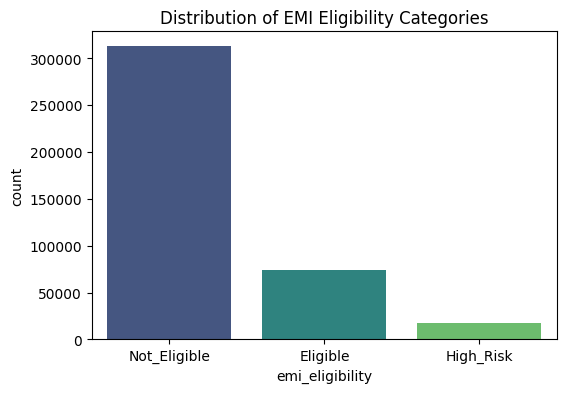

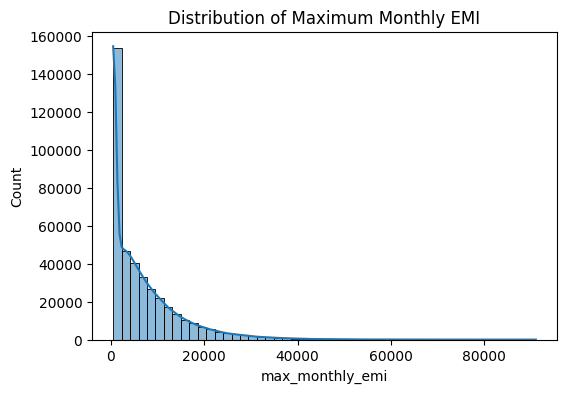

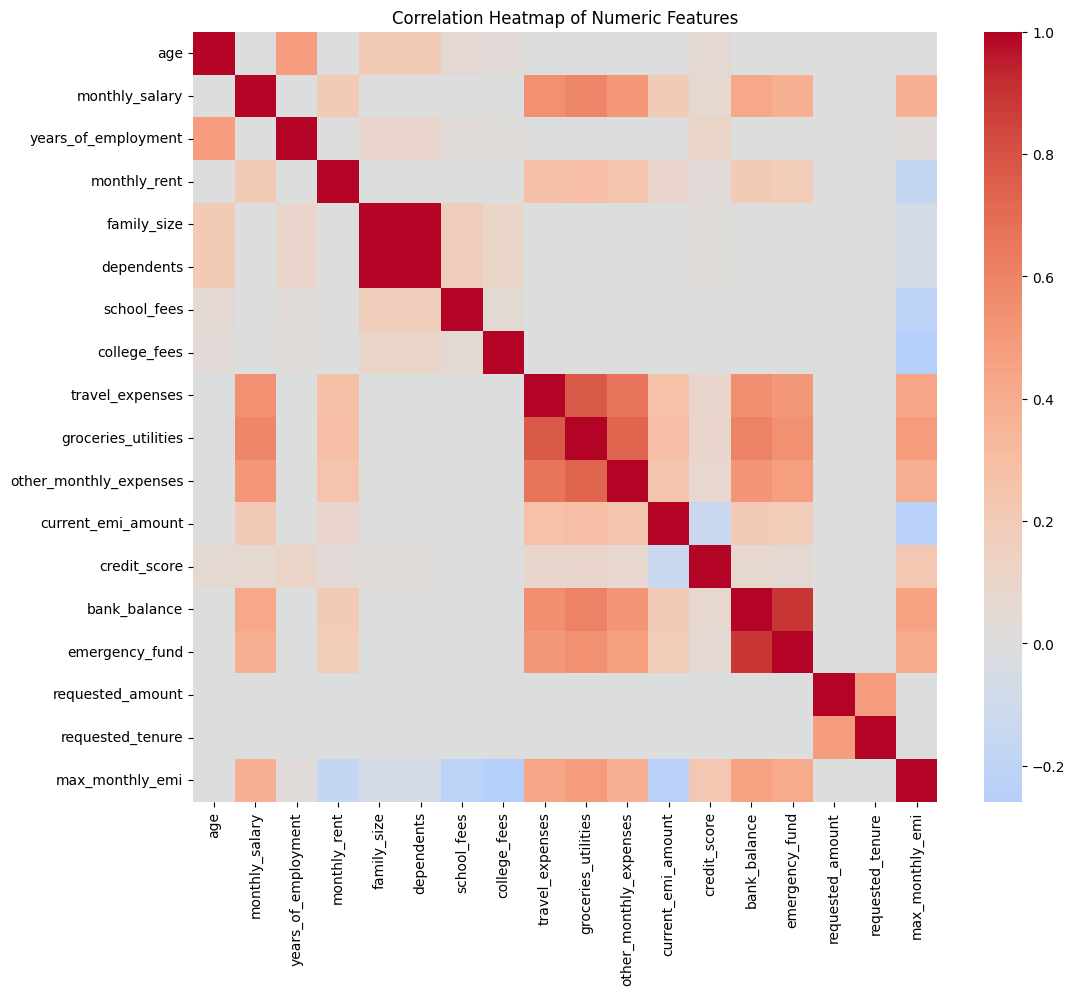

In [4]:
# Cell 7: Exploratory Data Analysis (EDA)
# -------------------------------------------------------------
# A few concise visualizations to understand class balance and target distribution.

if 'emi_eligibility' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='emi_eligibility', palette='viridis')
    plt.title('Distribution of EMI Eligibility Categories')
    plt.show()
else:
    print("Column 'emi_eligibility' not found — skipping class distribution plot.")

if 'max_monthly_emi' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['max_monthly_emi'].dropna(), bins=50, kde=True)
    plt.title('Distribution of Maximum Monthly EMI')
    plt.show()
else:
    print("Column 'max_monthly_emi' not found — skipping histogram.")

# Correlation heatmap for numeric features (trimmed if too many features)
num_df = df.select_dtypes(include=[np.number])
max_cols_for_plot = 40
if num_df.shape[1] > 1:
    cols_to_plot = num_df.columns.tolist()
    if len(cols_to_plot) > max_cols_for_plot:
        # pick top variance columns to keep the heatmap readable
        cols_to_plot = num_df.var().sort_values(ascending=False).head(max_cols_for_plot).index.tolist()
    plt.figure(figsize=(12,10))
    sns.heatmap(df[cols_to_plot].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

In [5]:
# Cell 8: Feature Engineering
# -------------------------------------------------------------
# Create robust derived features. We check whether the necessary columns exist first.
expense_cols = [c for c in ['groceries_utilities', 'travel_expenses', 'school_fees', 'college_fees', 'monthly_rent', 'other_monthly_expenses'] if c in df.columns]
if expense_cols:
    df['total_expenses'] = df[expense_cols].sum(axis=1)
else:
    # fallback: if no detailed expense columns are available, attempt to use a generic 'total_expenses' column
    if 'total_expenses' not in df.columns:
        df['total_expenses'] = 0

# DTI (Debt-to-Income): uses current EMI and requested amount if available
df['current_emi_amount'] = df['current_emi_amount'] if 'current_emi_amount' in df.columns else 0
req_amount = df['requested_amount'] if 'requested_amount' in df.columns else 0
salary = df['monthly_salary'] if 'monthly_salary' in df.columns else 1

# Avoid division by zero by adding a small epsilon
_eps = 1e-9

df['dti_ratio'] = (df['current_emi_amount'].fillna(0) + req_amount.fillna(0)) / (salary.fillna(0) + _eps)
df['savings_rate'] = (salary.fillna(0) - df['total_expenses'].fillna(0)) / (salary.fillna(0) + _eps)
df['expense_to_income'] = df['total_expenses'].fillna(0) / (salary.fillna(0) + _eps)

if 'credit_score' in df.columns:
    df['credit_health'] = df['credit_score'].fillna(0) / 1000.0
else:
    df['credit_health'] = 0.0

print("Feature engineering completed successfully.")

Feature engineering completed successfully.


In [6]:
# Cell 9: Encoding Categorical Features
# -------------------------------------------------------------
# Using Label Encoding for object columns. We keep a mapping for reproducibility.

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    # skip numeric-like object columns
    if col in ['emi_eligibility']:
        continue
    le = LabelEncoder()
    try:
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    except Exception as e:
        # if label encoding fails, leave the column as-is and report
        print(f"Warning: encoding column {col} failed with: {e}")

print(f"Categorical columns encoded: {len(label_encoders)}")

Categorical columns encoded: 8


In [7]:
# Cell 10: Splitting Data into Train-Test Sets
# -------------------------------------------------------------
# Prepare separate feature matrices for classification and regression tasks.

required_cols = df.columns.tolist()
if 'emi_eligibility' not in required_cols or 'max_monthly_emi' not in required_cols:
    raise KeyError("Both 'emi_eligibility' and 'max_monthly_emi' targets must be present in the dataset.")

# Classification
y_class = df['emi_eligibility']
X_class = df.drop(['emi_eligibility', 'max_monthly_emi'], axis=1)

# Regression
y_reg = df['max_monthly_emi']
X_reg = df.drop(['emi_eligibility', 'max_monthly_emi'], axis=1)

# If classification labels are strings, encode them into integers for model training
label_map = None
if y_class.dtype == 'object' or str(y_class.dtype).startswith('category'):
    unique_labels = y_class.unique().tolist()
    label_map = {lab: idx for idx, lab in enumerate(sorted(unique_labels))}
    y_class = y_class.map(label_map)

# Train-test splits
# For classification we stratify by class if possible
if len(np.unique(y_class)) > 1:
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)
else:
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Data split completed for both tasks.")
print(f"Classification train shape: {Xc_train.shape}, test shape: {Xc_test.shape}")
print(f"Regression train shape: {Xr_train.shape}, test shape: {Xr_test.shape}")

Data split completed for both tasks.
Classification train shape: (323840, 30), test shape: (80960, 30)
Regression train shape: (323840, 30), test shape: (80960, 30)


In [8]:
# Cell 11: Classification Models
# -------------------------------------------------------------
# Define and train multiple classification models. Each run is optionally logged to MLflow.

class_models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
}

if mlflow_available:
    mlflow.set_experiment('EMI_Classification')

class_results = {}

for name, model in class_models.items():
    print(f"Training classification model: {name}")
    with mlflow.start_run(run_name=name):
        model.fit(Xc_train, yc_train)
        preds = model.predict(Xc_test)
        acc = accuracy_score(yc_test, preds)
        report = classification_report(yc_test, preds, output_dict=True, zero_division=0)
        f1 = report.get('weighted avg', {}).get('f1-score', np.nan)

        # Log metrics if MLflow is available (or dummy object present)
        try:
            mlflow.log_metric('Accuracy', float(acc))
            mlflow.log_metric('F1_Score', float(f1))
            mlflow.sklearn.log_model(model, name)
        except Exception:
            # logging is best-effort; do not fail the pipeline if it doesn't work
            pass

        class_results[name] = {'accuracy': acc, 'f1': f1, 'model': model}

print("Classification training completed for all models.")


Training classification model: Logistic Regression


2025/11/07 22:40:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:40:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training classification model: Random Forest


2025/11/07 22:41:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:41:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training classification model: XGBoost


2025/11/07 22:41:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:41:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classification training completed for all models.


Best Classification Model: XGBoost — Accuracy: 0.9664


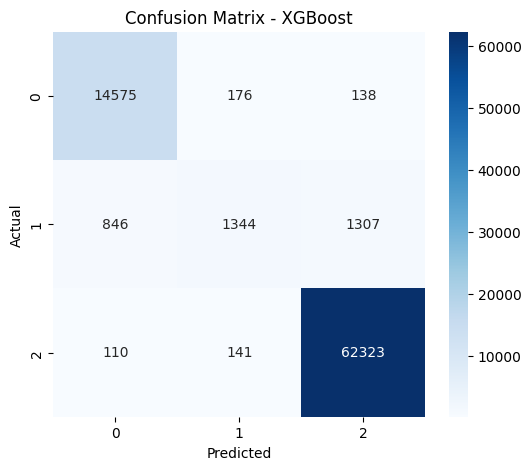


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14889
           1       0.81      0.38      0.52      3497
           2       0.98      1.00      0.99     62574

    accuracy                           0.97     80960
   macro avg       0.91      0.79      0.82     80960
weighted avg       0.96      0.97      0.96     80960



In [9]:
# Cell 12: Classification Evaluation
# -------------------------------------------------------------
# Select the best classification model by accuracy and show evaluation plots.

if not class_results:
    raise RuntimeError("No classification models were trained — please check the training step.")

best_class_name = max(class_results.keys(), key=lambda k: class_results[k]['accuracy'])
best_class = class_results[best_class_name]['model']
print(f"Best Classification Model: {best_class_name} — Accuracy: {class_results[best_class_name]['accuracy']:.4f}")

# Predictions and confusion matrix
preds_class = best_class.predict(Xc_test)
cm = confusion_matrix(yc_test, preds_class)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_class_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(yc_test, preds_class, zero_division=0))

In [10]:
# Cell 13: Regression Models
# -------------------------------------------------------------
# Define and train multiple regression models. Each run is optionally logged to MLflow.

reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=1, random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

if mlflow_available:
    mlflow.set_experiment('EMI_Regression')

reg_results = {}

for name, model in reg_models.items():
    print(f"Training regression model: {name}")
    with mlflow.start_run(run_name=name):
        model.fit(Xr_train, yr_train)
        preds = model.predict(Xr_test)
        rmse = np.sqrt(mean_squared_error(yr_test, preds))
        mae = mean_absolute_error(yr_test, preds)
        r2 = r2_score(yr_test, preds)

        try:
            mlflow.log_metric('RMSE', float(rmse))
            mlflow.log_metric('MAE', float(mae))
            mlflow.log_metric('R2_Score', float(r2))
            mlflow.sklearn.log_model(model, name)
        except Exception:
            pass

        reg_results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2, 'model': model}

print("Regression training completed for all models.")

Training regression model: Linear Regression


2025/11/07 22:41:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:41:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training regression model: Random Forest Regressor


2025/11/07 22:41:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:41:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training regression model: XGBoost Regressor


2025/11/07 22:41:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 22:41:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regression training completed for all models.


Best Regression Model: XGBoost Regressor — RMSE: 852.00


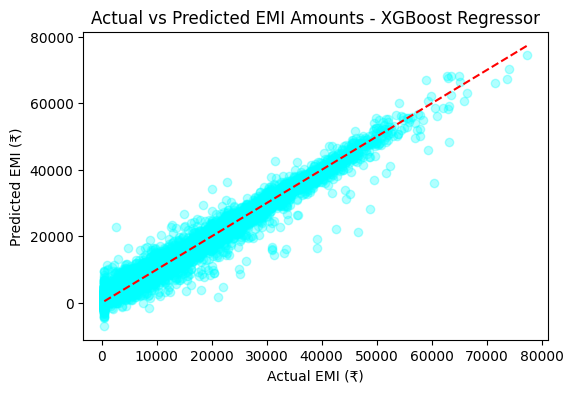


Regression Metrics:
RMSE: 852.00
MAE: 456.44
R2: 0.9877


In [12]:
# Cell 14: Regression Evaluation
# -------------------------------------------------------------
# Select best regression model by RMSE and show actual vs predicted scatter.

if not reg_results:
    raise RuntimeError("No regression models were trained — please check the training step.")

best_reg_name = min(reg_results.keys(), key=lambda k: reg_results[k]['rmse'])
best_reg = reg_results[best_reg_name]['model']
print(f"Best Regression Model: {best_reg_name} — RMSE: {reg_results[best_reg_name]['rmse']:.2f}")

preds_reg = best_reg.predict(Xr_test)
plt.figure(figsize=(6,4))
plt.scatter(yr_test, preds_reg, alpha=0.3, color='cyan')
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')
plt.title(f'Actual vs Predicted EMI Amounts - {best_reg_name}')
plt.xlabel('Actual EMI (₹)')
plt.ylabel('Predicted EMI (₹)')
plt.show()

# Basic regression metrics printout
print('\nRegression Metrics:')
print(f"RMSE: {reg_results[best_reg_name]['rmse']:.2f}")
print(f"MAE: {reg_results[best_reg_name]['mae']:.2f}")
print(f"R2: {reg_results[best_reg_name]['r2']:.4f}")


In [13]:
# Cell 15: Save Best Models
# -------------------------------------------------------------
# Ensure the models/ directory exists and save the best models for deployment.

models_dir = os.path.join('.', 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir, exist_ok=True)

classifier_path = os.path.join(models_dir, 'best_classifier.pkl')
regressor_path = os.path.join(models_dir, 'best_regressor.pkl')

with open(classifier_path, 'wb') as f:
    pickle.dump(best_class, f)

with open(regressor_path, 'wb') as f:
    pickle.dump(best_reg, f)

print(f"Best models saved to: {models_dir}")

Best models saved to: .\models


In [14]:
# Cell 16: Final Summary
# -------------------------------------------------------------
print("\n===== PROJECT SUMMARY =====")
print(f"Best Classification Model: {best_class_name} — Accuracy: {class_results[best_class_name]['accuracy']:.4f}")
print(f"Best Regression Model: {best_reg_name} — RMSE: {reg_results[best_reg_name]['rmse']:.2f}")
if mlflow_available:
    print("MLflow tracking was enabled — check your MLflow UI to review runs.")
else:
    print("MLflow was not available in this environment. Models were still trained and saved locally.")

print("All done. You can now use the models/ files with the Streamlit app for deployment.")


===== PROJECT SUMMARY =====
Best Classification Model: XGBoost — Accuracy: 0.9664
Best Regression Model: XGBoost Regressor — RMSE: 852.00
MLflow tracking was enabled — check your MLflow UI to review runs.
All done. You can now use the models/ files with the Streamlit app for deployment.
